In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [25]:
import pandas as pd
from src.config import TRANSFORMED_DATA_DIR

df = pd.read_parquet(TRANSFORMED_DATA_DIR / "tabular_data.parquet")

In [30]:
# Extract time-based features
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])
df['week_day'] = df['pickup_hour'].dt.weekday  
df['hour_of_day'] = df['pickup_hour'].dt.hour  

selected_lags = ['rides_t-1', 'rides_t-2', 'rides_t-3', 
                 'rides_t-24', 'rides_t-168', 'rides_t-672']

features = selected_lags + ['week_day', 'hour_of_day']
target = 'target'

In [42]:

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

train_size = int(0.8 * len(df))
train, test = df.iloc[:train_size], df.iloc[train_size:]

arma_order = (2, 0, 1)
arma_model = ARIMA(train[target], order=arma_order, exog=train[features]).fit()

# Make predictions
arma_preds = arma_model.forecast(steps=len(test), exog=test[features])

# Evaluate model
arma_mae = mean_absolute_error(test[target], arma_preds)
print(f"ARIMA{arma_order} MAE: {arma_mae}")

c:\Users\vidyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\vidyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\vidyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1) MAE: 3.7203006856959373



Best Model: ARIMA, MAE: 3.7203006856959373


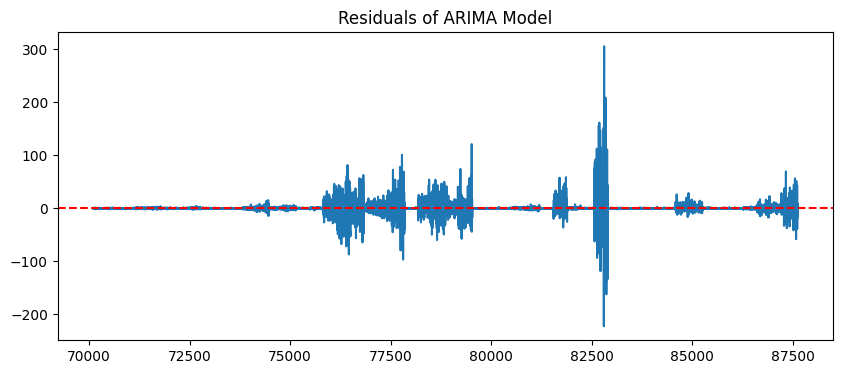

In [43]:
import matplotlib.pyplot as plt 

best_model, best_mae, best_preds = 'ARIMA', arma_mae, arma_preds
print(f"\nBest Model: {best_model}, MAE: {best_mae}")

# ===========================
# Residual Analysis
# ===========================
residuals = test[target] - best_preds
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='red')
plt.title(f"Residuals of {best_model} Model")
plt.show()

In [44]:
# Get in-sample predictions for training MAE
train_preds = arma_model.fittedvalues  # In-sample predictions
train_mae = mean_absolute_error(train[target], train_preds)

print(f"Training MAE: {train_mae}")
print(f"Test MAE: {arma_mae}")


Training MAE: 3.048829216677974
Test MAE: 3.7203006856959373


In [46]:
from src.experiment_utils import set_mlflow_tracking
from dotenv import load_dotenv
import mlflow
import os

# Load environment variables
load_dotenv()

# Set MLflow tracking
mlflow = set_mlflow_tracking()

# Train ARMA model
train_size = int(0.8 * len(df))
train, test = df.iloc[:train_size], df.iloc[train_size:]

arma_order = (2, 0, 1)
arma_model = ARIMA(train[target], order=arma_order, exog=train[features]).fit()

# Make predictions
arma_preds = arma_model.forecast(steps=len(test), exog=test[features])

# Evaluate model
arma_mae = mean_absolute_error(test[target], arma_preds)

# Get in-sample predictions for training MAE
train_preds = arma_model.fittedvalues
train_mae = mean_absolute_error(train[target], train_preds)

# Log to MLflow
with mlflow.start_run():
    mlflow.log_param("model_type", "ARIMA with FE")
    mlflow.log_param("order", arma_order)
    
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_mae", arma_mae)

    # Log the model
    mlflow.sklearn.log_model(arma_model, "ARMA_Model")

print(f"Logged ARMA model to MLflow with Train MAE: {train_mae}, Test MAE: {arma_mae}")


INFO:src.experiment_utils:MLflow tracking URI and credentials set.
c:\Users\vidyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\vidyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\vidyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
2025/02/23 21:03:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` param

🏃 View run ARIMA with Feature Engineering at: https://dagshub.com/vidyuthkrishna03/nyc-taxi-rides-prediction.mlflow/#/experiments/0/runs/68dd9034f22848ff86c87abb3af6a82a
🧪 View experiment at: https://dagshub.com/vidyuthkrishna03/nyc-taxi-rides-prediction.mlflow/#/experiments/0
Logged ARMA model to MLflow with Train MAE: 3.048829216677974, Test MAE: 3.7203006856959373
